# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band4.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.963001 -0.025542 -0.702739 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.963001 -0.025542 -0.702739 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.963001 -0.025542 -0.702739 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.963001 -0.025542 -0.702739 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.963001 -0.025542 -0.702739 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.916003  ...  -1.0 -0.886288 -0.881532  -1.0  -1.0 -0.525067   
      201547 -0.916003  ...  -1.0 -0.886288 -0.881532  -1.0  -1.0 -0.525067   
      201548 -0.916003  ...  -1.0 -0.886288 -0.881532  -1.0  -1.0 -0.525067   
      201549 -0.916003  ...  -1.0 -0.886288 -0.881532  -1.0  -1.0 -0.525067   
      201550 -0.916003  ...  -1.0 -0.886288 -0.881532  -1.0  -1.0 -0.525067   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.913278  -1.0 -0.861740  
      201547  -1.0 -0.913278  -1.0 -0.854589  
      201548  -1.0 -0.913278  -1.0 -0.856973  
      201549  -1.0 -0.913278  -1.0 -0.856973  
      201550  -1.0 -0.913278  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2        3    4    5         6    7  \
41001 201820 -1.0 -0.917877 -0.622330 -1.00000 -1.0 -1.0 -0.849690 -1.0   
      201821 -1.0 -1.000000 -0.980861 -0.86345 -1.0 -1.0 -0.993847 -1.0   
      201822 -1.0 -0.936922 -0.904049 -1.00000 -1.0 -1.0 -0.591156 -1.0   
      201823 -1.0 -0.739014 -0.802731 -1.00000 -1.0 -1.0 -1.000000 -1.0   
      201824 -1.0 -1.000000 -1.000000 -1.00000 -1.0 -1.0 -0.915848 -1.0   

                     8         9  ...      2039      2040  2041  2042  \
41001 201820 -0.998574 -0.948917  ... -0.953878 -0.417411  -1.0  -1.0   
      201821 -1.000000 -0.370790  ... -1.000000 -0.159749  -1.0  -1.0   
      201822 -0.953890 -1.000000  ... -1.000000 -0.440105  -1.0  -1.0   
      201823 -0.951314 -0.704176  ... -1.000000 -0.995999  -1.0  -1.0   
      201824 -0.956419 -1.000000  ... -1.000000 -0.751207  -1.0  -1.0   

                  2043      2044  2045      2046      2047    Labels  
41001 201820 -0.882208 -1.000000  -1.0 -0.980648 -1.000000 -0.949940  
      201821 -0.843839 -1.000000  -1.0 -0.645729 -0.958148 -0.961859  
      201822 -0.890683 -0.954669  -1.0 -0.719282 -0.960404 -0.940405  
      201823 -1.000000 -1.000000  -1.0 -1.000000 -1.000000 -0.961859  
      201824 -0.976408 -1.000000  -1.0 -0.364849 -0.949471 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

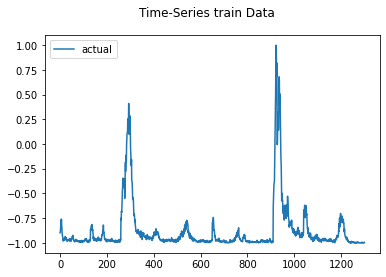

2023-03-07 13:10:48.107948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 13:10:48.108012: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 13:10:48.108065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 13:10:48.108577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:10:48.459915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 108.969
Test RMSE: 166.905
Test sMAPE: 138.478
Test R Squared: -27.826
{'mae': 108.968729549827, 'rmse': 166.90473352534224, 'smape': 138.4784953217385, 'r2': -27.825663272832244}


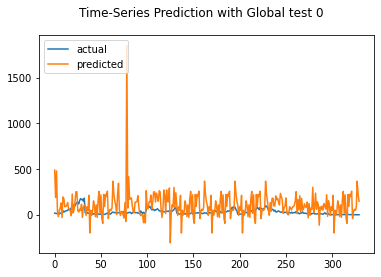

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 79.126
Test RMSE: 103.959
Test sMAPE: 127.393
Test R Squared: -10.183
{'mae': 79.1255717494271, 'rmse': 103.95867775284309, 'smape': 127.39254106748461, 'r2': -10.183133151457927}


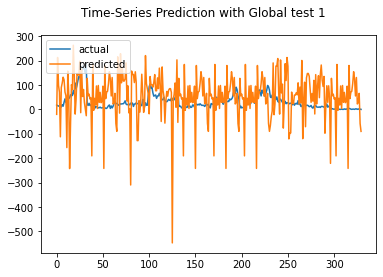

Test MAE: 37.771
Test RMSE: 99.442
Test sMAPE: 118.510
Test R Squared: -9.232
{'mae': 37.77114743400704, 'rmse': 99.44166112887137, 'smape': 118.51036233616328, 'r2': -9.232429060498502}


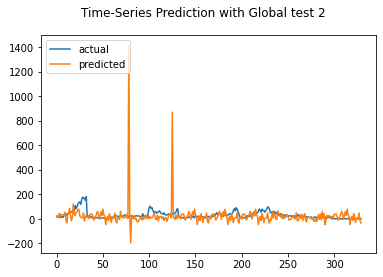

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 52.477
Test RMSE: 89.440
Test sMAPE: 111.960
Test R Squared: -7.278
{'mae': 52.4770847906669, 'rmse': 89.4404077556168, 'smape': 111.95954655083082, 'r2': -7.277697330692975}


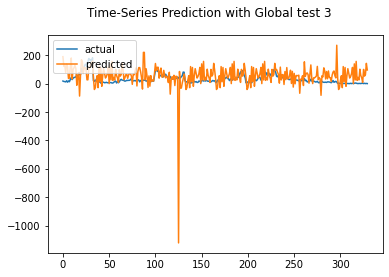

Test MAE: 48.027
Test RMSE: 76.803
Test sMAPE: 118.675
Test R Squared: -5.104
{'mae': 48.02688495318095, 'rmse': 76.80269890468027, 'smape': 118.67548049627534, 'r2': -5.103725093419239}


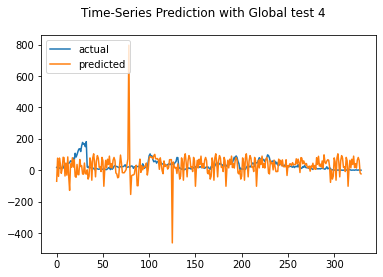

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 39.108
Test RMSE: 51.490
Test sMAPE: 102.092
Test R Squared: -1.743
{'mae': 39.108374025966185, 'rmse': 51.48995884929979, 'smape': 102.09175319585556, 'r2': -1.7433870935871365}


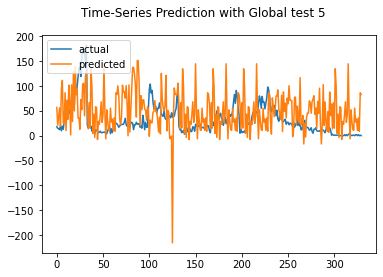

Test MAE: 57.487
Test RMSE: 140.526
Test sMAPE: 134.312
Test R Squared: -19.434
{'mae': 57.48668575937098, 'rmse': 140.5262485826077, 'smape': 134.31218355356532, 'r2': -19.43416552799518}


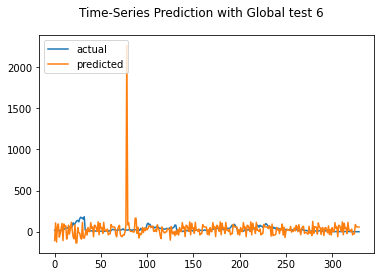

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 113.551
Test RMSE: 144.355
Test sMAPE: 160.997
Test R Squared: -20.563
{'mae': 113.55117857600703, 'rmse': 144.3554338864495, 'smape': 160.99674637222705, 'r2': -20.56295489728459}


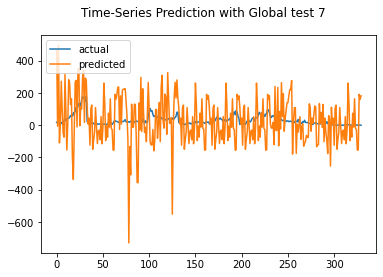

Test MAE: 63.540
Test RMSE: 119.484
Test sMAPE: 105.664
Test R Squared: -13.773
{'mae': 63.53980908249364, 'rmse': 119.48410278190333, 'smape': 105.66380801247759, 'r2': -13.772780848259558}


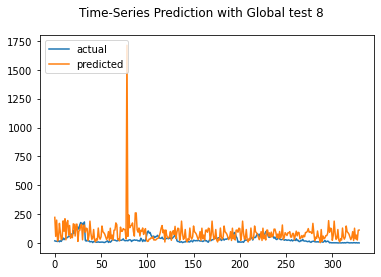

Test MAE: 34.848
Test RMSE: 45.612
Test sMAPE: 105.288
Test R Squared: -1.153
{'mae': 34.84805337768613, 'rmse': 45.61202400987318, 'smape': 105.28835005786459, 'r2': -1.1527851559494184}


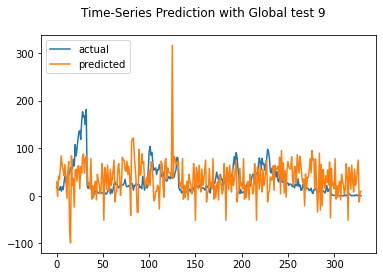

Test MAE: 43.720
Test RMSE: 98.200
Test sMAPE: 120.939
Test R Squared: -8.978
{'mae': 43.7198288698088, 'rmse': 98.19988461089376, 'smape': 120.93894910713097, 'r2': -8.97847001474699}


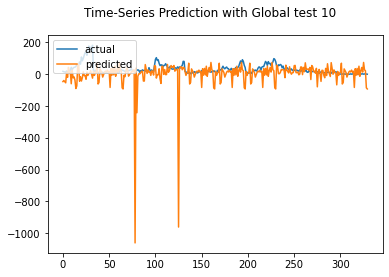

Test MAE: 80.861
Test RMSE: 132.431
Test sMAPE: 111.798
Test R Squared: -17.148
{'mae': 80.86113498391528, 'rmse': 132.430534946192, 'smape': 111.79763920768313, 'r2': -17.14756114650224}


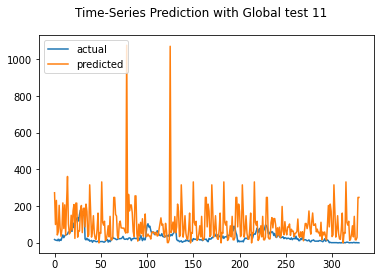

Test MAE: 62.419
Test RMSE: 114.621
Test sMAPE: 109.628
Test R Squared: -12.595
{'mae': 62.41879280697216, 'rmse': 114.62090777486203, 'smape': 109.62775610767866, 'r2': -12.59470190065193}


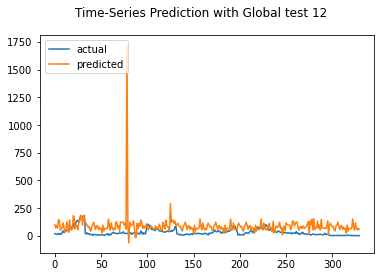

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 71.651
Test RMSE: 126.358
Test sMAPE: 134.188
Test R Squared: -15.521
{'mae': 71.65051795677705, 'rmse': 126.35819020469641, 'smape': 134.18761199747672, 'r2': -15.521474166892254}


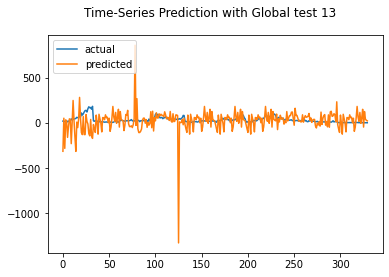

Test MAE: 53.404
Test RMSE: 107.532
Test sMAPE: 108.374
Test R Squared: -10.965
{'mae': 53.403857084205654, 'rmse': 107.53207173621627, 'smape': 108.37379800046452, 'r2': -10.965146704351067}


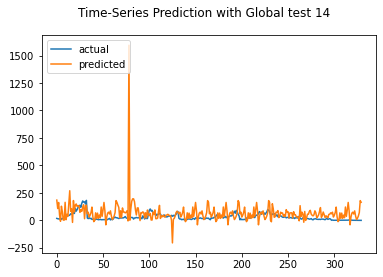

Test MAE: 67.735
Test RMSE: 190.213
Test sMAPE: 109.227
Test R Squared: -36.439
{'mae': 67.73452368378639, 'rmse': 190.2134000363109, 'smape': 109.22692243810921, 'r2': -36.4389981617791}


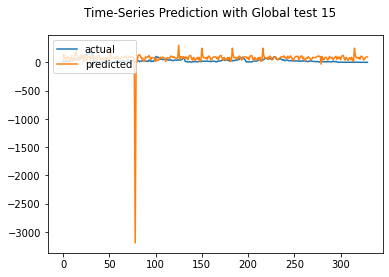

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 68.140
Test RMSE: 86.905
Test sMAPE: 143.409
Test R Squared: -6.815
{'mae': 68.14028603091384, 'rmse': 86.90511131940357, 'smape': 143.40941529643283, 'r2': -6.815065855872102}


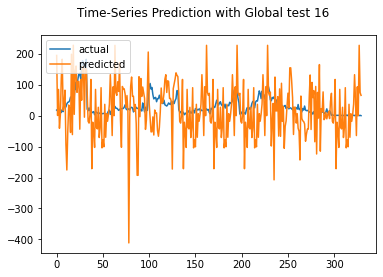

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 79.588
Test RMSE: 128.109
Test sMAPE: 138.696
Test R Squared: -15.982
{'mae': 79.5884843269984, 'rmse': 128.10874658414807, 'smape': 138.69574499250572, 'r2': -15.982419546455692}


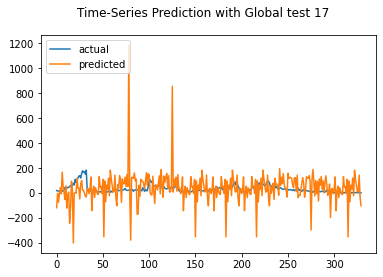

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 159.278
Test RMSE: 248.336
Test sMAPE: 155.423
Test R Squared: -62.815
{'mae': 159.27767286011667, 'rmse': 248.33627713361793, 'smape': 155.4228106190793, 'r2': -62.81493542601254}


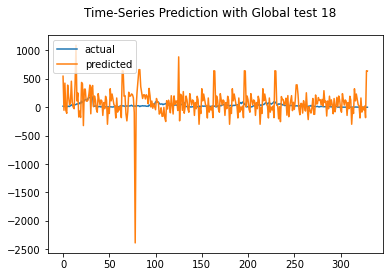

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 56.243
Test RMSE: 117.363
Test sMAPE: 123.787
Test R Squared: -13.253
{'mae': 56.24331936727871, 'rmse': 117.36306668584179, 'smape': 123.78748273230045, 'r2': -13.252954534283592}


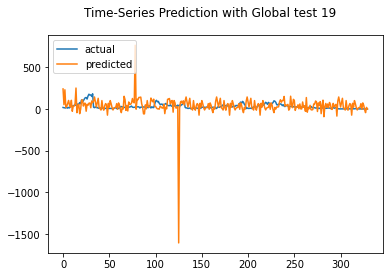

Test MAE: 52.046
Test RMSE: 72.684
Test sMAPE: 163.181
Test R Squared: -4.467
{'mae': 52.04627479974067, 'rmse': 72.68405957094544, 'smape': 163.18096950475172, 'r2': -4.466638466320318}


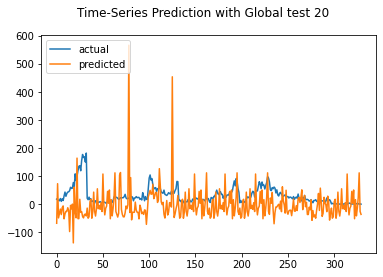

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 79.629
Test RMSE: 118.034
Test sMAPE: 137.741
Test R Squared: -13.416
{'mae': 79.62935146689415, 'rmse': 118.03421086783361, 'smape': 137.74082992588268, 'r2': -13.416432515947635}


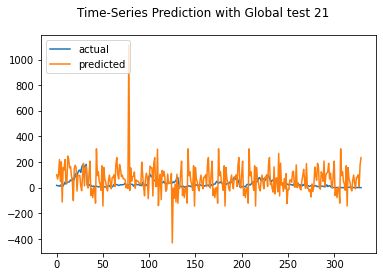

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 78.838
Test RMSE: 116.273
Test sMAPE: 152.064
Test R Squared: -12.989
{'mae': 78.83761992165536, 'rmse': 116.27292093834677, 'smape': 152.0642561038218, 'r2': -12.98940254057833}


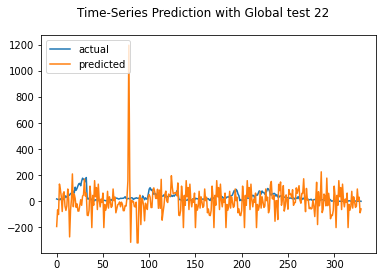

Test MAE: 46.767
Test RMSE: 87.709
Test sMAPE: 94.149
Test R Squared: -6.960
{'mae': 46.767466281760825, 'rmse': 87.70947974624849, 'smape': 94.14940092956549, 'r2': -6.960403309918265}


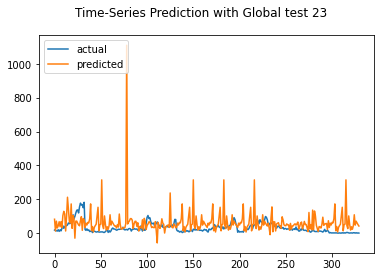

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 83.920
Test RMSE: 111.662
Test sMAPE: 140.137
Test R Squared: -11.902
{'mae': 83.91959734252005, 'rmse': 111.66175650356274, 'smape': 140.13707270690807, 'r2': -11.901818029540872}


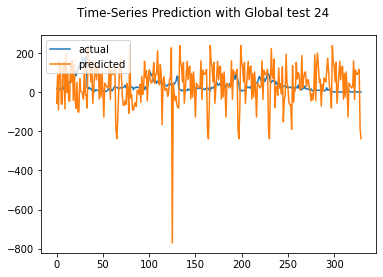

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 106.381
Test RMSE: 163.434
Test sMAPE: 145.999
Test R Squared: -26.639
{'mae': 106.38123938910888, 'rmse': 163.4341972699171, 'smape': 145.99908844543992, 'r2': -26.63935284994318}


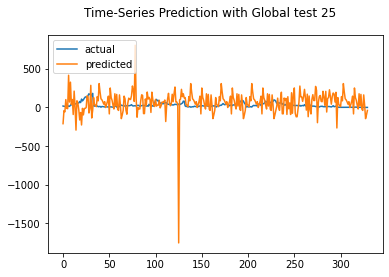

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 92.559
Test RMSE: 130.344
Test sMAPE: 147.008
Test R Squared: -16.580
{'mae': 92.55887588515427, 'rmse': 130.34425618770805, 'smape': 147.0075888311612, 'r2': -16.580280408289028}


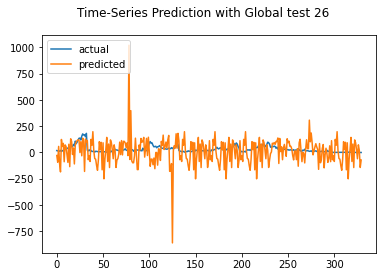

Test MAE: 80.110
Test RMSE: 114.715
Test sMAPE: 113.278
Test R Squared: -12.617
{'mae': 80.10977438724402, 'rmse': 114.71493785383359, 'smape': 113.27762416745531, 'r2': -12.617016070969845}


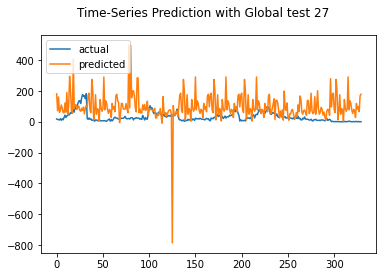

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 41.766
Test RMSE: 55.365
Test sMAPE: 129.276
Test R Squared: -2.172
{'mae': 41.76567999106465, 'rmse': 55.36459363787337, 'smape': 129.27553358407124, 'r2': -2.1718032148638575}


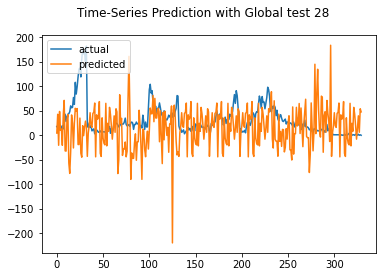

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 36.333
Test RMSE: 45.313
Test sMAPE: 101.857
Test R Squared: -1.125
{'mae': 36.33317921450644, 'rmse': 45.31269448291584, 'smape': 101.85671035424484, 'r2': -1.1246225054134964}


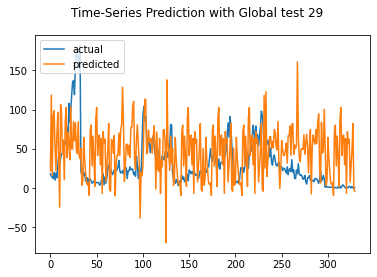

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 153.428
Test RMSE: 205.467
Test sMAPE: 161.482
Test R Squared: -42.684
{'mae': 153.42815587141297, 'rmse': 205.46720097503032, 'smape': 161.48214645641988, 'r2': -42.684463967520095}


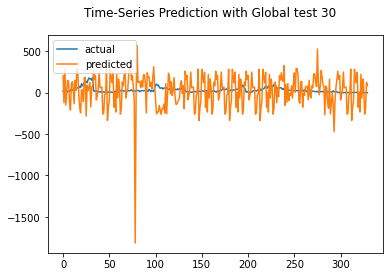

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 51.909
Test RMSE: 74.767
Test sMAPE: 130.119
Test R Squared: -4.784
{'mae': 51.90866135449121, 'rmse': 74.76671647831866, 'smape': 130.11942897582927, 'r2': -4.7844040040373255}


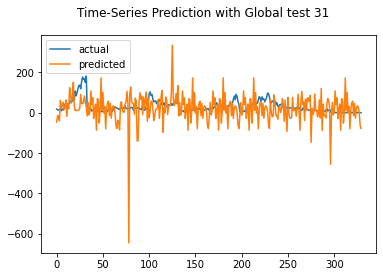

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 80.784
Test RMSE: 114.340
Test sMAPE: 135.363
Test R Squared: -12.528
{'mae': 80.78363185868119, 'rmse': 114.34025275531546, 'smape': 135.3634643584495, 'r2': -12.528208792601067}


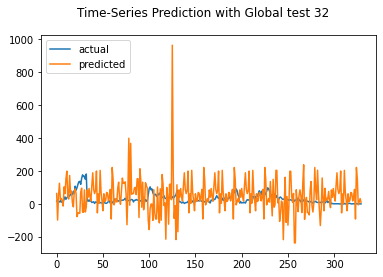

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 49.558
Test RMSE: 150.440
Test sMAPE: 105.204
Test R Squared: -22.419
{'mae': 49.558410838878515, 'rmse': 150.43997017294498, 'smape': 105.20383736955326, 'r2': -22.41900713724922}


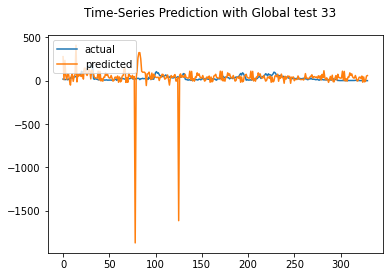

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 89.016
Test RMSE: 146.427
Test sMAPE: 126.713
Test R Squared: -21.186
{'mae': 89.01596714556217, 'rmse': 146.42721807128274, 'smape': 126.71290896169525, 'r2': -21.18633797415885}


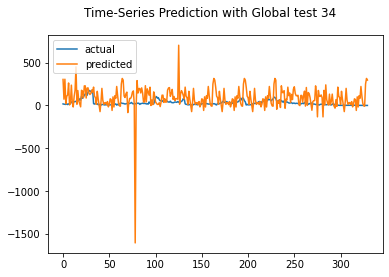

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 56.519
Test RMSE: 106.529
Test sMAPE: 110.094
Test R Squared: -10.743
{'mae': 56.51924983768752, 'rmse': 106.52910291236175, 'smape': 110.09399837894584, 'r2': -10.74298595091687}


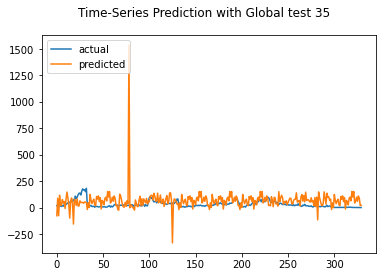

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 107.445
Test RMSE: 212.891
Test sMAPE: 141.308
Test R Squared: -45.898
{'mae': 107.44522000171922, 'rmse': 212.89147477612508, 'smape': 141.30807350663056, 'r2': -45.898455744097596}


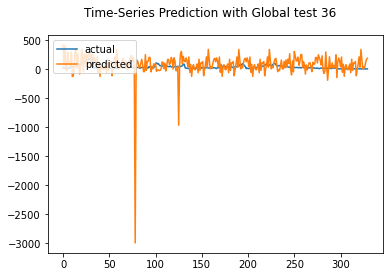

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 46.666
Test RMSE: 59.953
Test sMAPE: 109.893
Test R Squared: -2.719
{'mae': 46.66637805104256, 'rmse': 59.9532684689334, 'smape': 109.8933250778072, 'r2': -2.7193558422489366}


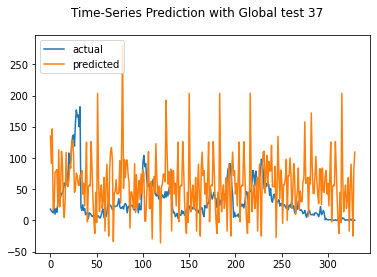

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 74.302
Test RMSE: 168.675
Test sMAPE: 131.122
Test R Squared: -28.440
{'mae': 74.30221741343989, 'rmse': 168.67477026534755, 'smape': 131.1222704554608, 'r2': -28.440301701849123}


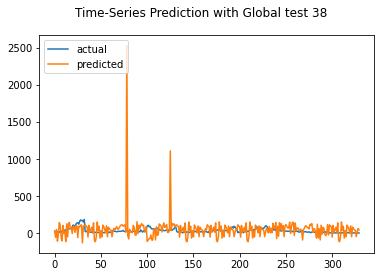

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 40.255
Test RMSE: 89.682
Test sMAPE: 98.719
Test R Squared: -7.323
{'mae': 40.255329457196325, 'rmse': 89.68235007312695, 'smape': 98.71872830187698, 'r2': -7.322541357669875}


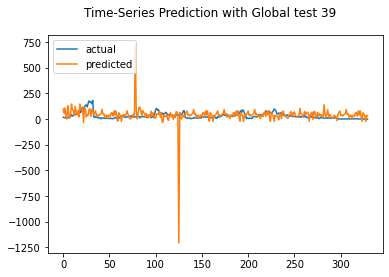

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.456
Test RMSE: 72.175
Test sMAPE: 104.939
Test R Squared: -4.390
{'mae': 43.455982782985224, 'rmse': 72.17490872653929, 'smape': 104.93933589443743, 'r2': -4.3903192577993515}


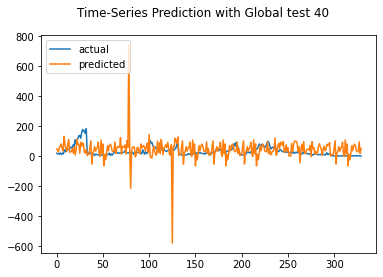

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 61.499
Test RMSE: 95.357
Test sMAPE: 109.082
Test R Squared: -8.409
{'mae': 61.499101808576874, 'rmse': 95.3571536028172, 'smape': 109.0824028360845, 'r2': -8.409110298500677}


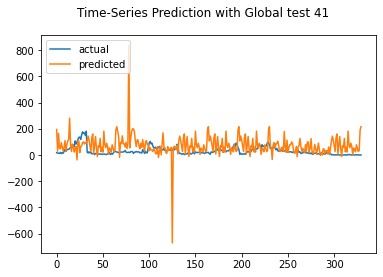

Test MAE: 45.374
Test RMSE: 109.689
Test sMAPE: 134.603
Test R Squared: -11.450
{'mae': 45.37411215829127, 'rmse': 109.68945493380151, 'smape': 134.60253933248296, 'r2': -11.450069003172718}


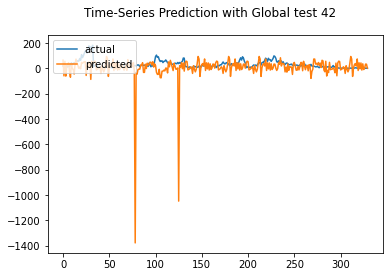

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 42.008
Test RMSE: 59.910
Test sMAPE: 111.892
Test R Squared: -2.714
{'mae': 42.00849920113881, 'rmse': 59.90962587350708, 'smape': 111.89204573737992, 'r2': -2.7139428509087775}


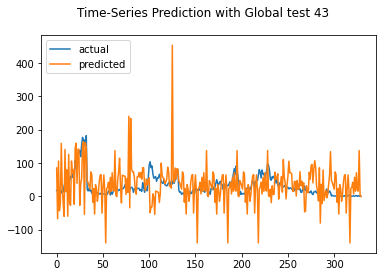

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 90.983
Test RMSE: 149.395
Test sMAPE: 141.600
Test R Squared: -22.095
{'mae': 90.98258076364344, 'rmse': 149.3953710281307, 'smape': 141.60019692496087, 'r2': -22.094910526898154}


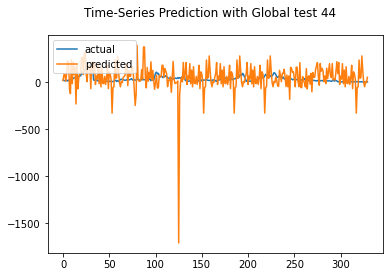

Test MAE: 84.191
Test RMSE: 179.018
Test sMAPE: 114.989
Test R Squared: -32.162
{'mae': 84.19084868142099, 'rmse': 179.0183562774778, 'smape': 114.98850866678708, 'r2': -32.161726413257576}


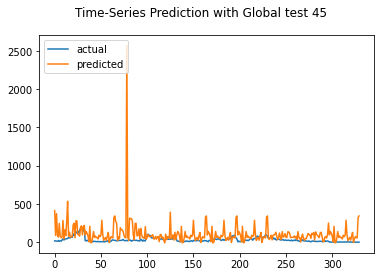

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 83.359
Test RMSE: 143.878
Test sMAPE: 129.188
Test R Squared: -20.420
{'mae': 83.35854059340376, 'rmse': 143.87755608137908, 'smape': 129.18768806120474, 'r2': -20.420426123488213}


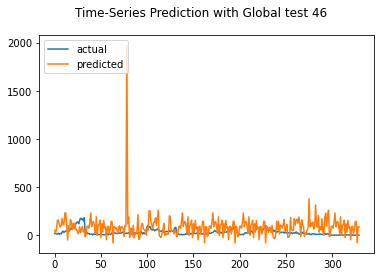

Test MAE: 80.770
Test RMSE: 116.627
Test sMAPE: 130.625
Test R Squared: -13.075
{'mae': 80.76984673034062, 'rmse': 116.6274841625589, 'smape': 130.62463375112102, 'r2': -13.074851333788448}


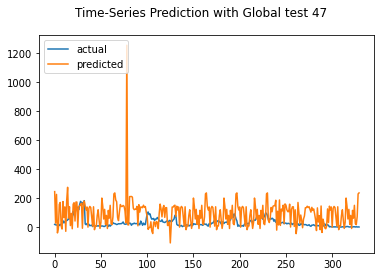

Test MAE: 68.090
Test RMSE: 146.884
Test sMAPE: 120.156
Test R Squared: -21.325
{'mae': 68.08956873091785, 'rmse': 146.88439843485287, 'smape': 120.15628737991699, 'r2': -21.325096230483876}


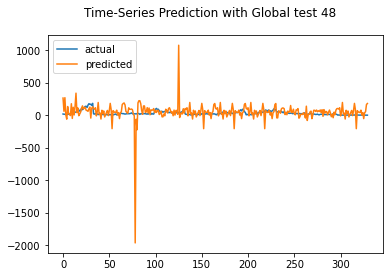

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 68.180
Test RMSE: 92.264
Test sMAPE: 132.613
Test R Squared: -7.809
{'mae': 68.17993888620174, 'rmse': 92.26405000450215, 'smape': 132.61318774562073, 'r2': -7.808602868072988}


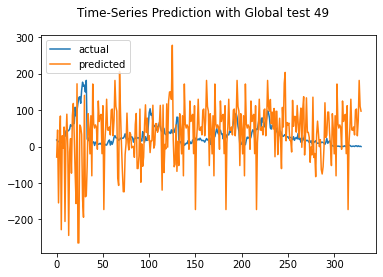

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 129.873
Test RMSE: 168.765
Test sMAPE: 148.914
Test R Squared: -28.472
{'mae': 129.8732983291149, 'rmse': 168.7652321665304, 'smape': 148.91365585361666, 'r2': -28.47188840347523}


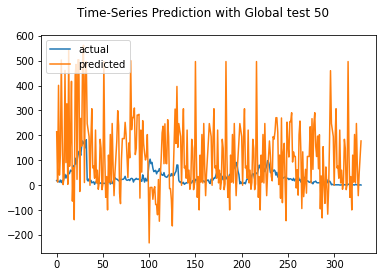

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.019
Test RMSE: 80.272
Test sMAPE: 106.168
Test R Squared: -5.668
{'mae': 40.018740913000975, 'rmse': 80.27152374174732, 'smape': 106.16770329575137, 'r2': -5.667530570974704}


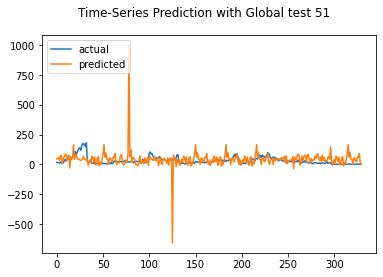

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 175.955
Test RMSE: 224.134
Test sMAPE: 151.027
Test R Squared: -50.982
{'mae': 175.95462653998172, 'rmse': 224.13380303575386, 'smape': 151.02652375178832, 'r2': -50.982447306746025}


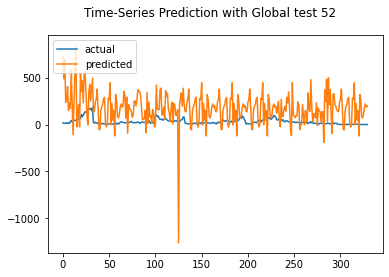

Test MAE: 62.630
Test RMSE: 87.371
Test sMAPE: 120.068
Test R Squared: -6.899
{'mae': 62.629819704908314, 'rmse': 87.37067712428716, 'smape': 120.06804319782616, 'r2': -6.8990234784898155}


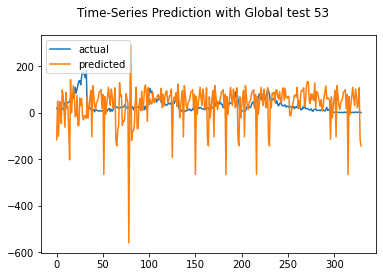

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 118.141
Test RMSE: 137.263
Test sMAPE: 157.826
Test R Squared: -18.496
{'mae': 118.14129156199368, 'rmse': 137.26292556036114, 'smape': 157.82587180612555, 'r2': -18.49613411332512}


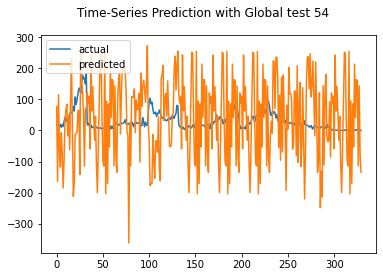

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 73.609
Test RMSE: 98.014
Test sMAPE: 138.742
Test R Squared: -8.941
{'mae': 73.60919415806279, 'rmse': 98.01351186745559, 'smape': 138.74156574627958, 'r2': -8.940629846794092}


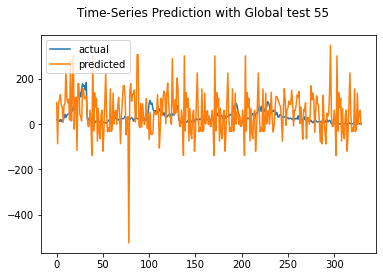

Test MAE: 66.974
Test RMSE: 116.544
Test sMAPE: 114.955
Test R Squared: -13.055
{'mae': 66.97424258029822, 'rmse': 116.54431600748394, 'smape': 114.95496167209525, 'r2': -13.054784673666344}


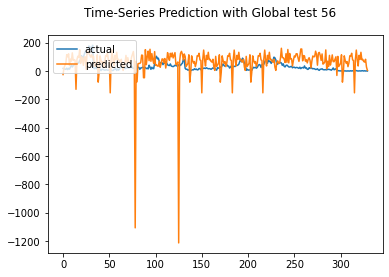

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 55.673
Test RMSE: 128.003
Test sMAPE: 104.691
Test R Squared: -15.954
{'mae': 55.67322995834278, 'rmse': 128.0027567723913, 'smape': 104.69079179182637, 'r2': -15.954330615672454}


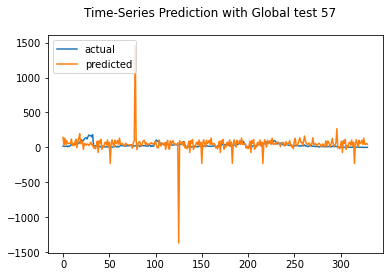

Test MAE: 80.392
Test RMSE: 122.141
Test sMAPE: 130.999
Test R Squared: -14.437
{'mae': 80.39163514818206, 'rmse': 122.1405361030203, 'smape': 130.99925609438696, 'r2': -14.436955258559433}


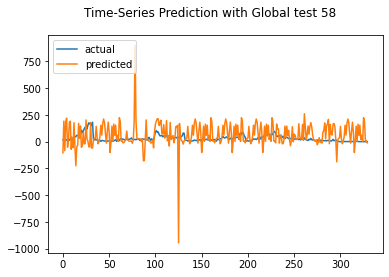

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 83.758
Test RMSE: 114.523
Test sMAPE: 130.629
Test R Squared: -12.572
{'mae': 83.75806739718625, 'rmse': 114.52347005674041, 'smape': 130.62866726360494, 'r2': -12.571598372170744}


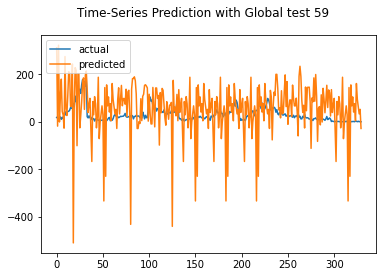

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 55.008
Test RMSE: 100.763
Test sMAPE: 115.372
Test R Squared: -9.506
{'mae': 55.00771890679995, 'rmse': 100.76281584313294, 'smape': 115.3720366520536, 'r2': -9.506125700192914}


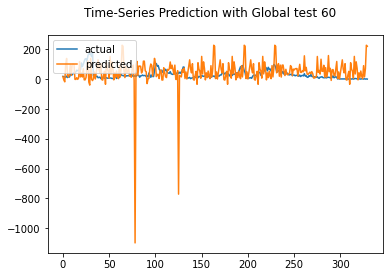

Test MAE: 51.298
Test RMSE: 77.607
Test sMAPE: 121.303
Test R Squared: -5.232
{'mae': 51.29819186474338, 'rmse': 77.60718952331014, 'smape': 121.3034736796477, 'r2': -5.232265034016375}


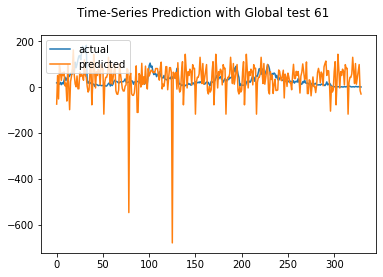

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 148.646
Test RMSE: 191.439
Test sMAPE: 142.905
Test R Squared: -36.923
{'mae': 148.64562840082428, 'rmse': 191.43944442700052, 'smape': 142.9053050670314, 'r2': -36.92318914758958}


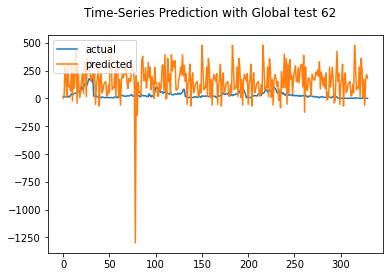

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 79.639
Test RMSE: 126.516
Test sMAPE: 134.571
Test R Squared: -15.563
{'mae': 79.63907707288409, 'rmse': 126.51554734406587, 'smape': 134.57097474135793, 'r2': -15.562649031626087}


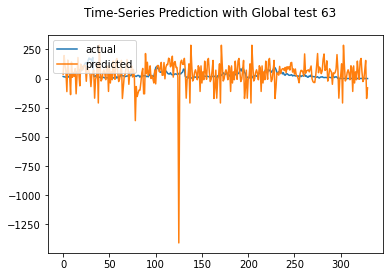

Test MAE: 62.092
Test RMSE: 84.277
Test sMAPE: 109.840
Test R Squared: -6.350
{'mae': 62.09197363708959, 'rmse': 84.2768520972436, 'smape': 109.84031311822147, 'r2': -6.349513850251806}


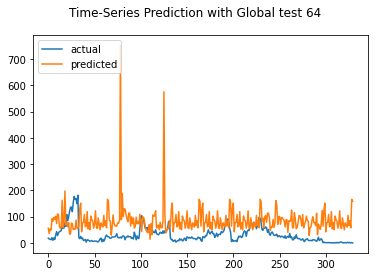

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 83.242
Test RMSE: 108.047
Test sMAPE: 150.183
Test R Squared: -11.080
{'mae': 83.24227624698119, 'rmse': 108.04659146566891, 'smape': 150.1830368371374, 'r2': -11.07992236700031}


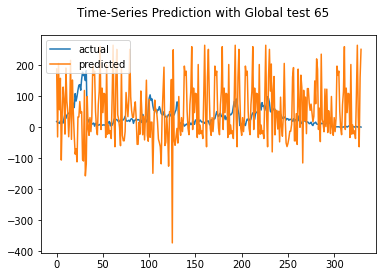

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 117.357
Test RMSE: 149.135
Test sMAPE: 147.632
Test R Squared: -22.015
{'mae': 117.35663356781006, 'rmse': 149.13532510170066, 'smape': 147.6323901766431, 'r2': -22.014579919577184}


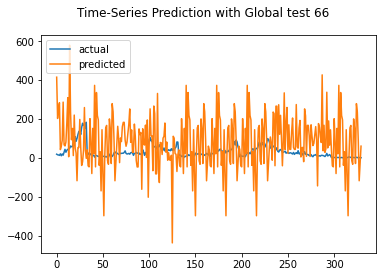

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 75.643
Test RMSE: 123.572
Test sMAPE: 130.536
Test R Squared: -14.801
{'mae': 75.6433255934354, 'rmse': 123.57171742689162, 'smape': 130.53553650842312, 'r2': -14.800839691691294}


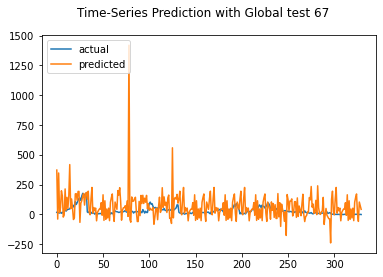

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 81.918
Test RMSE: 126.776
Test sMAPE: 124.098
Test R Squared: -15.631
{'mae': 81.91843099666364, 'rmse': 126.77552583829747, 'smape': 124.09795747096994, 'r2': -15.630788589261197}


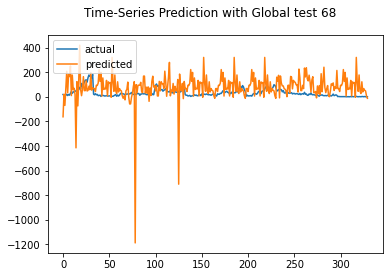

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 59.912
Test RMSE: 90.158
Test sMAPE: 122.674
Test R Squared: -7.411
{'mae': 59.91211167393309, 'rmse': 90.15757383497717, 'smape': 122.67423984324329, 'r2': -7.410976781115444}


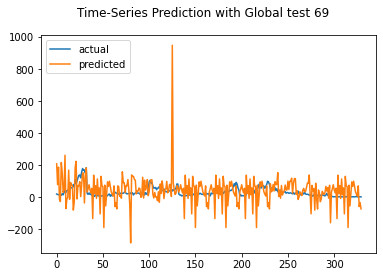

Test MAE: 77.344
Test RMSE: 238.419
Test sMAPE: 111.725
Test R Squared: -57.820
{'mae': 77.34386091268424, 'rmse': 238.41885735396696, 'smape': 111.72492371551648, 'r2': -57.81975431395524}


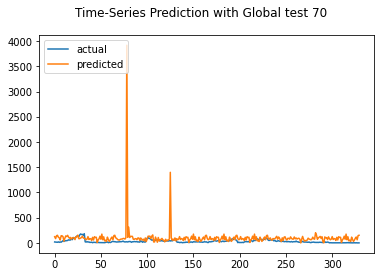

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 62.218
Test RMSE: 109.645
Test sMAPE: 110.605
Test R Squared: -11.440
{'mae': 62.218063377792184, 'rmse': 109.64534178974712, 'smape': 110.60450341533682, 'r2': -11.440057079033144}


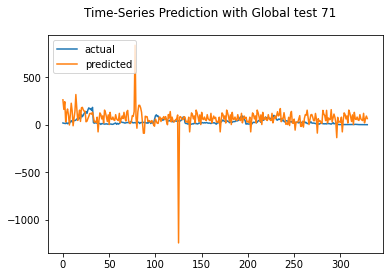

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 96.825
Test RMSE: 162.104
Test sMAPE: 162.351
Test R Squared: -26.191
{'mae': 96.82472678260369, 'rmse': 162.10379955982384, 'smape': 162.35122226663427, 'r2': -26.19120101690539}


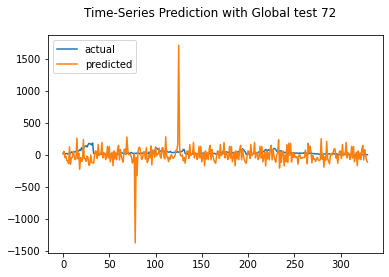

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 93.444
Test RMSE: 125.963
Test sMAPE: 136.986
Test R Squared: -15.418
{'mae': 93.44401255557031, 'rmse': 125.96314805574923, 'smape': 136.98571850377502, 'r2': -15.418331248339275}


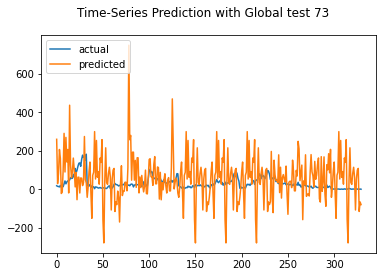

Test MAE: 41.116
Test RMSE: 82.050
Test sMAPE: 95.142
Test R Squared: -5.966
{'mae': 41.116440773913354, 'rmse': 82.04976917254965, 'smape': 95.14231612009989, 'r2': -5.966212671137279}


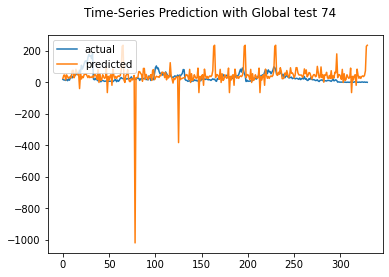

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 76.760
Test RMSE: 169.779
Test sMAPE: 126.040
Test R Squared: -28.827
{'mae': 76.75995841676539, 'rmse': 169.77861030112618, 'smape': 126.04020337510339, 'r2': -28.826888482875187}


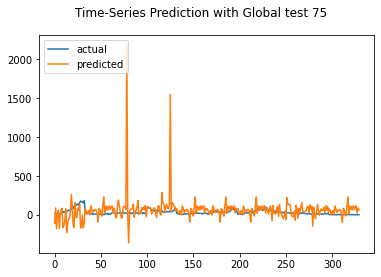

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 83.436
Test RMSE: 108.161
Test sMAPE: 133.740
Test R Squared: -11.106
{'mae': 83.43601037841854, 'rmse': 108.16141773891306, 'smape': 133.73992568329155, 'r2': -11.105611831376045}


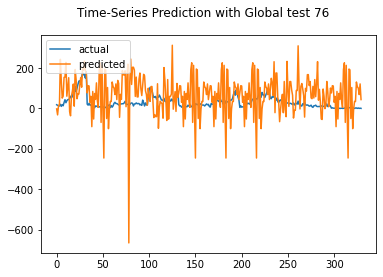

Test MAE: 52.954
Test RMSE: 130.208
Test sMAPE: 109.225
Test R Squared: -16.544
{'mae': 52.95354318952921, 'rmse': 130.20829954703777, 'smape': 109.22487530415731, 'r2': -16.543625025068813}


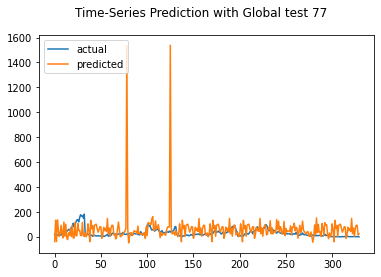

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 92.992
Test RMSE: 120.183
Test sMAPE: 145.004
Test R Squared: -13.946
{'mae': 92.99208303111972, 'rmse': 120.18310770912908, 'smape': 145.0043943591654, 'r2': -13.946133647880863}


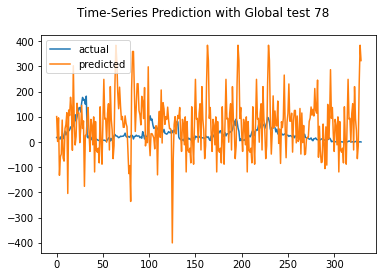

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 88.954
Test RMSE: 137.218
Test sMAPE: 141.854
Test R Squared: -18.483
{'mae': 88.95440027894396, 'rmse': 137.21759950220505, 'smape': 141.85377848025792, 'r2': -18.483260469505257}


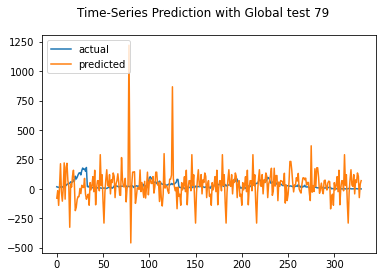

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 43.187
Test RMSE: 57.523
Test sMAPE: 129.979
Test R Squared: -2.424
{'mae': 43.18749538009817, 'rmse': 57.52258769506535, 'smape': 129.97852453233332, 'r2': -2.4238823356141306}


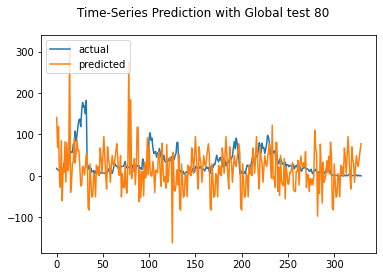

Test MAE: 60.247
Test RMSE: 141.323
Test sMAPE: 104.482
Test R Squared: -19.667
{'mae': 60.246514679085124, 'rmse': 141.32308352523697, 'smape': 104.48198909082474, 'r2': -19.666560850221714}


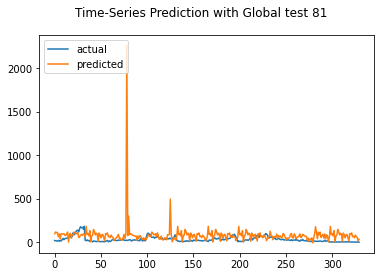

Test MAE: 121.427
Test RMSE: 256.059
Test sMAPE: 159.595
Test R Squared: -66.846
{'mae': 121.42737214511091, 'rmse': 256.05895450764564, 'smape': 159.59535557479876, 'r2': -66.84563905039104}


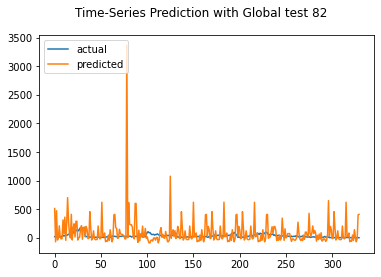

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 90.859
Test RMSE: 190.139
Test sMAPE: 143.463
Test R Squared: -36.410
{'mae': 90.85863998008497, 'rmse': 190.13946828396226, 'smape': 143.46271215841386, 'r2': -36.40990039240069}


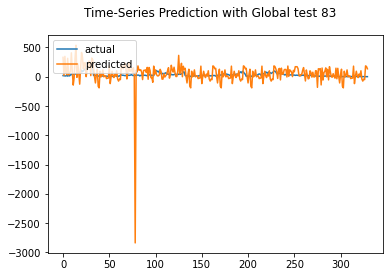

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 85.497
Test RMSE: 134.168
Test sMAPE: 138.015
Test R Squared: -17.627
{'mae': 85.4966613291791, 'rmse': 134.1682015407589, 'smape': 138.01488196311544, 'r2': -17.626926388281227}


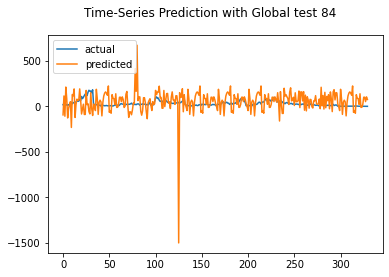

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 104.955
Test RMSE: 133.410
Test sMAPE: 152.358
Test R Squared: -17.417
{'mae': 104.95536827824333, 'rmse': 133.41033229970756, 'smape': 152.35780259299, 'r2': -17.417086738610458}


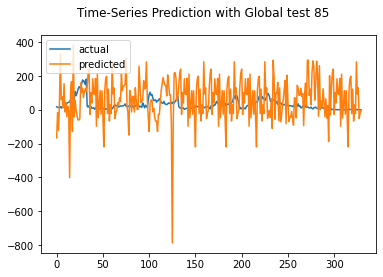

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 109.097
Test RMSE: 135.950
Test sMAPE: 133.830
Test R Squared: -18.125
{'mae': 109.0970917503039, 'rmse': 135.94960345146703, 'smape': 133.8297435626656, 'r2': -18.12484358672304}


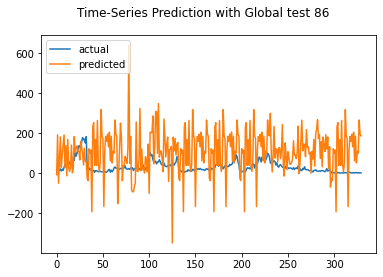

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 76.039
Test RMSE: 107.292
Test sMAPE: 126.713
Test R Squared: -10.912
{'mae': 76.0391193187598, 'rmse': 107.29165338451634, 'smape': 126.7131448256695, 'r2': -10.911703577475308}


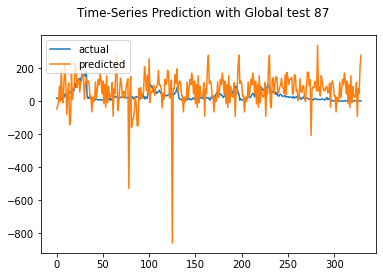

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 52.138
Test RMSE: 63.721
Test sMAPE: 123.060
Test R Squared: -3.202
{'mae': 52.13837327559789, 'rmse': 63.72114586832845, 'smape': 123.06002938551104, 'r2': -3.20154631720927}


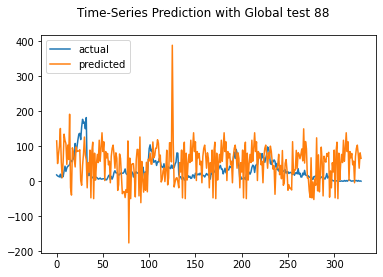

Test MAE: 74.551
Test RMSE: 153.353
Test sMAPE: 106.847
Test R Squared: -23.335
{'mae': 74.55116924336463, 'rmse': 153.3534406727937, 'smape': 106.84704687591271, 'r2': -23.334871112312957}


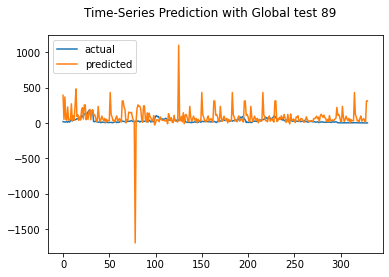

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 55.211
Test RMSE: 84.307
Test sMAPE: 108.082
Test R Squared: -6.355
{'mae': 55.21125076593775, 'rmse': 84.30702858344507, 'smape': 108.08246816518883, 'r2': -6.354777981597665}


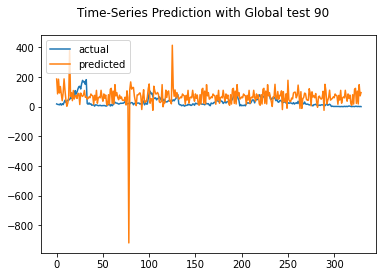

Test MAE: 64.606
Test RMSE: 93.469
Test sMAPE: 149.227
Test R Squared: -8.040
{'mae': 64.60559825716597, 'rmse': 93.46886791280316, 'smape': 149.22735310492965, 'r2': -8.040156873354059}


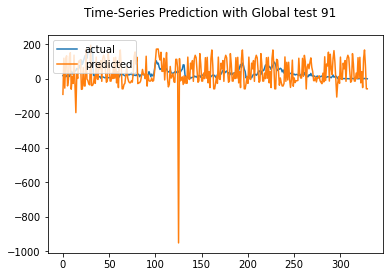

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.468
Test RMSE: 73.653
Test sMAPE: 139.131
Test R Squared: -4.613
{'mae': 50.46829116281235, 'rmse': 73.6532213599692, 'smape': 139.1307778017834, 'r2': -4.613393587657992}


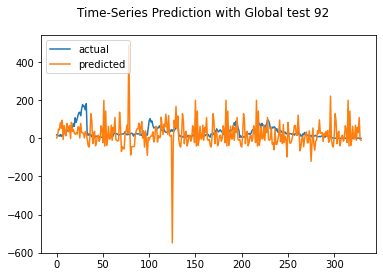

Test MAE: 88.027
Test RMSE: 164.549
Test sMAPE: 117.498
Test R Squared: -27.018
{'mae': 88.02669910120241, 'rmse': 164.54918417471652, 'smape': 117.4976558918083, 'r2': -27.017763723667777}


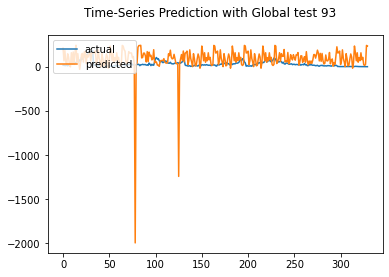

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 98.553
Test RMSE: 154.520
Test sMAPE: 139.324
Test R Squared: -23.707
{'mae': 98.55307912320802, 'rmse': 154.52041499472259, 'smape': 139.32361613625093, 'r2': -23.7066426281807}


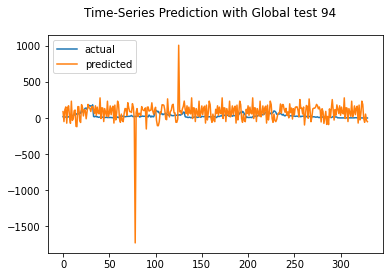

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 83.086
Test RMSE: 103.538
Test sMAPE: 128.745
Test R Squared: -10.093
{'mae': 83.08616465510744, 'rmse': 103.5377647762319, 'smape': 128.7445324470196, 'r2': -10.092758846137592}


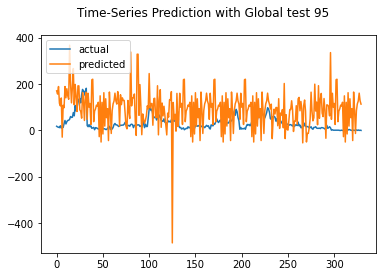

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 97.117
Test RMSE: 142.508
Test sMAPE: 140.956
Test R Squared: -20.015
{'mae': 97.11709238272725, 'rmse': 142.50786226645494, 'smape': 140.95579098133575, 'r2': -20.01452860343104}


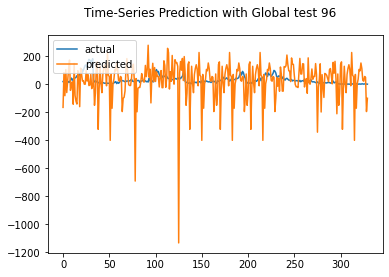

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 135.365
Test RMSE: 245.888
Test sMAPE: 141.136
Test R Squared: -61.563
{'mae': 135.36532538370653, 'rmse': 245.88793473011884, 'smape': 141.13644142427128, 'r2': -61.562837853737186}


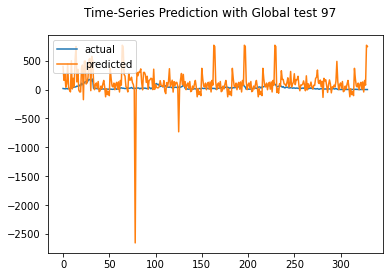

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 72.394
Test RMSE: 132.377
Test sMAPE: 132.316
Test R Squared: -17.133
{'mae': 72.39361400784868, 'rmse': 132.37684724229868, 'smape': 132.31622299423537, 'r2': -17.13284998645924}


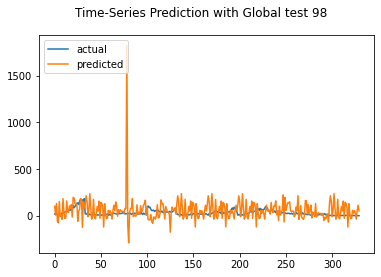

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 99.948
Test RMSE: 195.402
Test sMAPE: 135.891
Test R Squared: -38.509
{'mae': 99.94774766907547, 'rmse': 195.40183233670385, 'smape': 135.89074500349577, 'r2': -38.5092936556765}


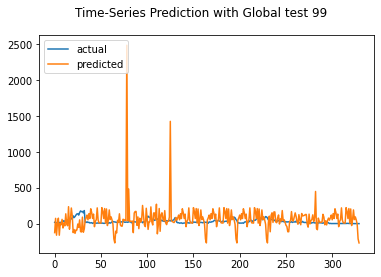

rmse : average=125.002, std=45.061
mae : average=76.247, std=28.211
smape : average=128.097, std=17.060
r2 : average=-17.270, std=13.618


([125.00184645018462, 45.0611014824179],
 [76.24678519954284, 28.21074451010953],
 [128.09682480493234, 17.05965314996329],
 [-17.26978548807441, 13.6184490886844])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')